In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

from utils import NormalDistribution

plt.rcParams['figure.figsize'] = (10,4)

np.random.seed(42)

## How to estimate the background distribution

As we saw in the previous example, if we know the _background_ distribution we can get the optimal Bayes, thus achieving the minimum possible error. However we need to estimate this _background_ with little or no samples.

### (k+1)-class posterior probabilities

Lets formalize the problem by deffining the different classes and their probabilities. Following the previous example we will have $k$ known classes; that we call _foreground_, and $1$ extra class that aggregates all the unknown classes; that we call _background_. These classes are $y \in \{1,\dots,k,k+1\}$ where $k+1$ corresponds to the aggregated _background_. Then, given the instantiation $X=x$ we can compute the posterior probabilites $p(Y=y_i|X=x)$. We will simplify our notation refering to $Y=y_i$ with $i \in \{1, \dots, k\}$ as $f_i$, and to $Y=y_{k+1}$ as $b$, also we will use $x$ to deonte $X=x$. Then we have the following posterior probabilities as:

$$p(f_1|x),\dots ,p(f_k|x), p(b|x)$$

where

$$ p(b|x) + \sum_{i \in \{1,\dots , k\}} p(f_i|x) = 1$$

We call this (k+1)-class posterior probabilities.

### Class posterior probabiliites within foreground

However, given the lack of _background_ information we can only get the posterior probabilities from the _foerground_ classes. In this case, if we use any multi-class classifier trained on the _foreground_ classes what we really obtain is:

$$p(f_1|f,x), \dots, p(f_k|f,x)$$

where

$$ \sum_{i \in \{1,\dots , k\}} p(f_i|f,x) = 1$$

This posterior probabilites also sum to one, and we refere to this ones as class posterior probabilities withing foreground.

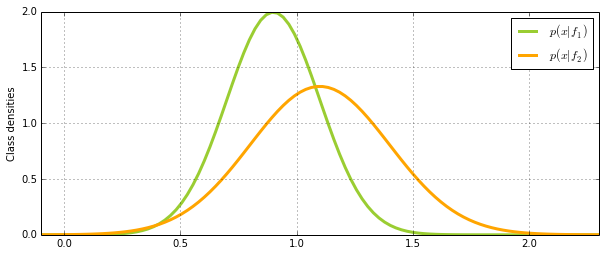

In [2]:
norm_f1 = NormalDistribution(mu=0.9, sigma=0.2)
norm_f2 = NormalDistribution(mu=1.1, sigma=0.3)

p_f1 = 0.4
p_f2 = 0.6

x_min = np.min([norm_f1.mu-4*norm_f1.sigma, norm_f2.mu-4*norm_f2.sigma])
x_max = np.max([norm_f1.mu+4*norm_f1.sigma, norm_f2.mu+4*norm_f2.sigma])

x_lin = np.linspace(x_min, x_max, 100)

p_x_g_f1 = norm_f1.pdf(x_lin)
p_x_g_f2 = norm_f2.pdf(x_lin)

plt.plot(x_lin, p_x_g_f1, color='yellowgreen', label='$p(x|f_1)$', linewidth=3)
plt.plot(x_lin, p_x_g_f2, color='orange', label='$p(x|f_2)$', linewidth=3)
plt.ylabel('Class densities')
plt.legend()
plt.xlim([x_min, x_max])
plt.grid(True)

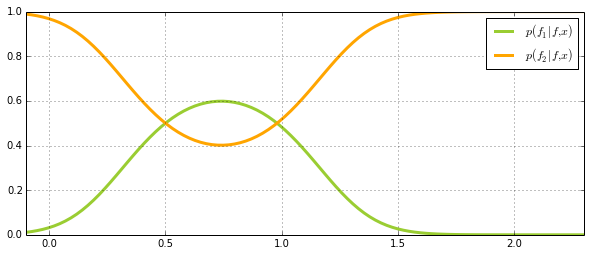

In [3]:
p_x = p_x_g_f1*p_f1 + p_x_g_f2*p_f2

p_f1_g_f_x = (p_x_g_f1*p_f1)/p_x
p_f2_g_f_x = (p_x_g_f2*p_f2)/p_x

plt.plot(x_lin, p_f1_g_f_x, color='yellowgreen', label='$p(f_1|f, x)$', linewidth=3)
plt.plot(x_lin, p_f2_g_f_x, color='orange', label='$p(f_2|f, x)$', linewidth=3)
plt.legend()
plt.xlim([x_min, x_max])
plt.grid(True)

### Obtaining the (k+1)-class posterior probabilities

It is possible to obtain the (k+1)-class posterior probabilities only with the class posterior probabilities within the foreground and a familiarity ratio defined as:

$$r(x) = \frac{p(f|x)}{p(b|x)}$$

From it we can get the posterior probability of the _background_

$$p(b|x) = \frac{1}{1/p(b|x)} = \frac{1}{(p(b|x)+p(f|x))/p(b|x)} = \frac{1}{1+r(x)}$$

Similarly it is possible to compute the k-class posterior probabilities

$$p(f_c|x) = p(f_c, f|x) = p(f_c|f,x)\frac{p(f|x)}{p(b|x)}p(b|x) = \frac{p(f_c|f,x)r(x)}{1+r(x)}$$

### E.g. constant familiarity ratio

As an example, imagine that we assume that the _foreground_ and the _background_ densities are the same trhough all the input space but with a different ratio. Here there is an example with different ratio values.

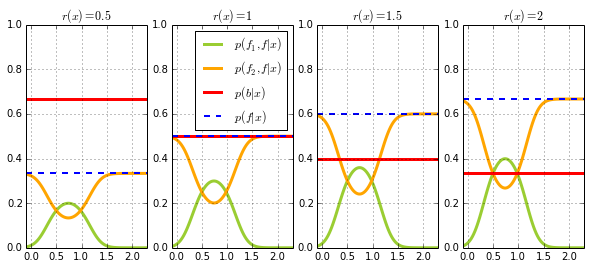

In [4]:
rs = [0.5, 1, 1.5, 2]

for i, r in enumerate(rs):
    plt.subplot(1,len(rs),i+1)
    p_b_g_x = np.ones_like(x_lin)/(1+r)

    p_f1_g_x = p_f1_g_f_x*r/(1+r)
    p_f2_g_x = p_f2_g_f_x*r/(1+r)

    plt.plot(x_lin, p_f1_g_x, color='yellowgreen', label='$p(f_1,f| x)$', linewidth=3)
    plt.plot(x_lin, p_f2_g_x, color='orange', label='$p(f_2,f| x)$', linewidth=3)
    plt.plot(x_lin, p_b_g_x, color='red', label='$p(b|x)$', linewidth=3)
    plt.plot(x_lin, p_f1_g_x+p_f2_g_x, '--', color='blue', label='$p(f|x)$', linewidth=2)
    plt.xlim([x_min, x_max])
    plt.ylim([0,1])
    plt.grid(True)
    plt.title("$r(x) = {}$".format(r))
    
    if i == 1:
        plt.legend()

### E.g. non-constant familiarity ratio

Another example could be if we assume that the _background_ class comes from a Normal distribution with more variance than the _foreground_. In this case the _foreground_ posterior probability will be higher on its mean, while it will be lower in farther regions.

$$ r(x) = \frac{p(f|x)}{p(b|x)} = \frac{p(f,x)p(x)}{p(b,x)p(x)} = \frac{p(f,x)}{p(b,x)}$$

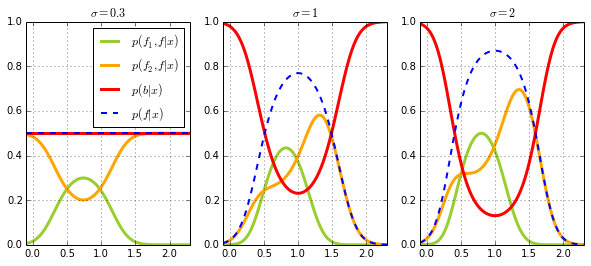

In [5]:
norm_f = NormalDistribution(mu=1, sigma=0.3)
p_f_x = norm_f.pdf(x_lin)

sigmas = [0.3,1,2]

for i, sigma in enumerate(sigmas):
    norm_b = NormalDistribution(mu=1, sigma=sigma)

    p_b_x = norm_b.pdf(x_lin)

    r = p_f_x/p_b_x
    
    plt.subplot(1,len(sigmas),i+1)
    p_b_g_x = np.ones_like(x_lin)/(1+r)

    p_f1_g_x = p_f1_g_f_x*r/(1+r)
    p_f2_g_x = p_f2_g_f_x*r/(1+r)

    plt.plot(x_lin, p_f1_g_x, color='yellowgreen', label='$p(f_1,f| x)$', linewidth=3)
    plt.plot(x_lin, p_f2_g_x, color='orange', label='$p(f_2,f| x)$', linewidth=3)
    plt.plot(x_lin, p_b_g_x, color='red', label='$p(b|x)$', linewidth=3)
    plt.plot(x_lin, p_f1_g_x+p_f2_g_x, '--', color='blue', label='$p(f|x)$', linewidth=2)
    plt.xlim([x_min, x_max])
    plt.ylim([0,1])
    plt.grid(True)
    plt.title("$\sigma = {}$".format(sigma))
    if i==0:
        plt.legend()

## Familiarity ratio

Because we are only interested in the ratio between the _foreground_ and the _background_ classes we can define a relative density $q_f(x)$ for the _foreground_ and $q_b(x)$ for the _background_ as follows:

$$
q_f(x) = \frac{p(x,f)}{\max_x p(x,f)}, \\
q_b(x) = \frac{p(x,b)}{\max_x p(x,f)}
$$

Then we can use these two functions instead of the real densities to compute the familiarity ratio

$$r(x)=\frac{p(x,f)}{p(x,b)} = \frac{q_f(x) \max_x p(x,f)}{q_b(x) \max_x p(x,f)} = \frac{q_f(x)}{q_b(x)}$$

Furthermore, it is possible to estimate the relative _foreground_ density estimation from the likelihood $p(x|f)$ and in the other way around as:

$$
q_f(x) = \frac{p(x|f)}{\max_xp(x|f)}, \\
p(x|f) = \frac{q_f(x)}{\int_x q_f(x) \,dx}
$$

## Estimating the Relative _Foreground_/_Background_ Densities

For that reason, we will need to infer the density of the background given the only information available from the _foreground_. In the absense of knowledge we will argue four different _inductive biases_ each one stronger than the previous one.

### 1st Inductive bias:

The _background_ density has any function $\mu$ with rescpect to the _foreground_ density

$$q_b(x) = \mu(q_f(x))$$    

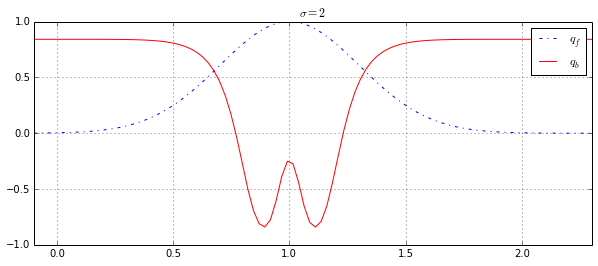

In [6]:
norm_f = NormalDistribution(mu=1, sigma=0.3)

q_f = norm_f.pdf(x_lin)
q_f /= q_f.max()
q_b = np.sin(np.cos(np.tan(q_f*1.35)))

plt.plot(x_lin, q_f, '-.', color='blue', label='$q_f$', linewidth=1)
plt.plot(x_lin, q_b, '-', color='red', label='$q_b$', linewidth=1)
plt.xlim([x_min, x_max])
plt.grid(True)
plt.title("$\sigma = {}$".format(sigma))
plt.legend()

### 2nd Inductive bias: monotonic background bias

The _backgrond_ denstiy is monotonically increasing or decreasing with respect to the _foreground_

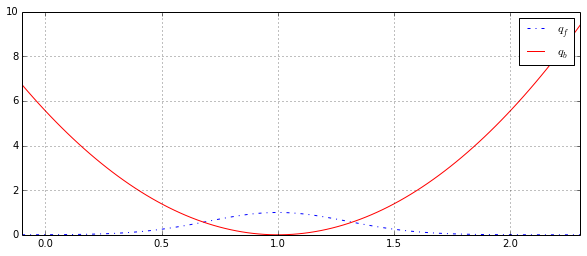

In [7]:
norm_f = NormalDistribution(mu=1, sigma=0.3)

q_f = norm_f.pdf(x_lin)
q_f /= q_f.max()
q_b = -np.log(q_f)

plt.plot(x_lin, q_f, '-.', color='blue', label='$q_f$', linewidth=1)
plt.plot(x_lin, q_b, '-', color='red', label='$q_b$', linewidth=1)
plt.xlim([x_min, x_max])
plt.grid(True)
plt.legend()

### 3rd Inductive bias: affine background bias

The _backgrond_ denstiy is monotonically incresing or decreasing within fixed bounds $\mu(0)$ and $\mu(1)$.

$$ q_b(x) = (1-q_f(x))\mu(0) + q_f(x)\mu(1)$$

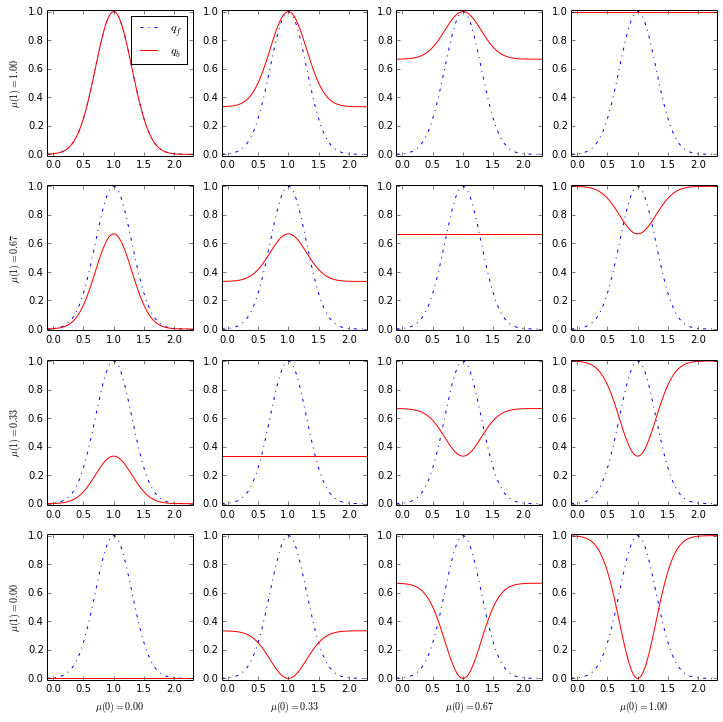

In [8]:
norm_f = NormalDistribution(mu=1, sigma=0.3)

q_f = norm_f.pdf(x_lin)
max_p_x_f = q_f.max()
q_f /= max_p_x_f

fig = plt.figure(figsize=(12,12))

n_values = 4
values = np.linspace(0,1,n_values)
for i, mu1 in enumerate(reversed(values)):
    for j, mu0 in enumerate(values):
        plt.subplot(n_values, n_values, i*n_values+j+1)
        q_b = (1-q_f)*mu0 + q_f*mu1

        plt.plot(x_lin, q_f, '-.', color='blue', label='$q_f$', linewidth=1)
        plt.plot(x_lin, q_b, '-', color='red', label='$q_b$', linewidth=1)
        
        plt.xlim([x_min, x_max])
        plt.ylim([-0.01,1.01])
        
        if i==0 and j==0:
            plt.legend()
        
        if i == n_values-1:
            plt.xlabel('$\mu(0) = {:.2f}$'.format(mu0))
        if j == 0:
            plt.ylabel('$\mu(1) = {:.2f}$'.format(mu1))

### 4th nductive bias: constant background bias

The _background_ density is constant in all the feature space. This is a particualr case in which $\mu(0) = \mu(1) = 0.5$

$$ q_b(x) = (1-q_f(x))0.5 + q_f(x)0.5 = 0.5 $$

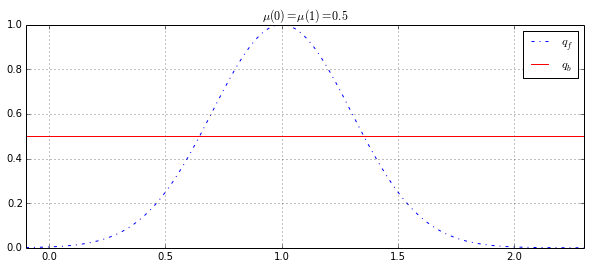

In [9]:
norm_f = NormalDistribution(mu=1, sigma=0.3)

q_f = norm_f.pdf(x_lin)
q_f /= q_f.max()
q_b = (1-q_f)*0.5 + q_f*0.5

plt.plot(x_lin, q_f, '-.', color='blue', label='$q_f$', linewidth=1)
plt.plot(x_lin, q_b, '-', color='red', label='$q_b$', linewidth=1)
plt.xlim([x_min, x_max])
plt.grid(True)
plt.title("$\mu(0) = \mu(1) = 0.5$")
plt.legend()